In [1]:
import os
import sys
print(sys.executable)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('..')
from get_data import FILE_NAMES

%matplotlib inline

/home/andreib/miniconda/envs/csc2305/bin/python


In [2]:
%pwd

'/home/andreib/work/numerics-from-scratch/csc2305/project/analysis'

In [3]:
# Each point in the reconstruction is just a 3D point, so it has three parameters.
PARAMS_PER_POINT = 3
# Each camera has a 6 DoF 3D rigid pose, plus three intrinsic parameters: focal length (same x and y),
# and two radial distorsion params.
PARAMS_PER_CAMERA = 6 + 3

SEQUENCE_NAMES = ['trafalgar', 'venice']
# dubrovnik, ladybug are the others. 'final' is a set of gigantic problems which should
# probably be solved using a compute cluster.

EXP_ROOT = os.path.join('..', 'experiments', '00')
assert len(os.listdir(EXP_ROOT)), "The experiment directory should not be empty."

In [4]:
files = os.listdir(EXP_ROOT)
seq = 'trafalgar'

print(FILE_NAMES[seq])

['problem-21-11315-pre.txt', 'problem-39-18060-pre.txt', 'problem-50-20431-pre.txt', 'problem-126-40037-pre.txt', 'problem-138-44033-pre.txt', 'problem-161-48126-pre.txt', 'problem-170-49267-pre.txt', 'problem-174-50489-pre.txt', 'problem-193-53101-pre.txt', 'problem-201-54427-pre.txt', 'problem-206-54562-pre.txt', 'problem-215-55910-pre.txt', 'problem-225-57665-pre.txt', 'problem-257-65132-pre.txt']


In [5]:
from collections import namedtuple

ExperimentParams = namedtuple(
    'ExperimentParams', 
    ['min_type', 'tr_strategy', 'dogleg_type', 'linear_solver_type', 'line_search_type', 'nlcg_type'])

def parse_meta(meta_fpath):
    with open(meta_fpath, 'r') as meta_file:
        raw_line = meta_file.readlines()[0]
        #     TRUST_REGION,LEVENBERG_MARQUARDT,TRADITIONAL_DOGLEG,DENSE_SCHUR,LBFGS,FLETCHER_REEVES
        return ExperimentParams(*(raw_line.strip().split(',')))

def parse_raw(raw_fpath):
    n_residuals = -3
    with open(raw_fpath, 'r') as raw_file:
        for line in raw_file.readlines():
            if 'residuals' in line.lower():
                n_residuals = int(line.split()[1])

    if -3 == n_residuals:
        raise ValueError("Could not parse raw file!")
    return n_residuals

In [6]:
def ap_list(m, key, element):
    if key not in m:
        m[key] = []
    m[key].append(element)

def load_files(root, sequence_name = 'trafalgar'):
    files = os.listdir(root)
    
    agg = {
        category: { } for category in ['lm', 'dogleg', 'linesearch']
    }
    
    for file in files:
        if file.endswith(".csv") and sequence_name in file:
            _, seq_name, _, n_images_s, n_points_s, *_ = file.split('-')
            n_images = int(n_images_s)
            n_points = int(n_points_s)
            
            params = parse_meta(os.path.join(root, file.replace('.csv', '.meta.txt')))
            n_residuals = parse_raw(os.path.join(root, file.replace('.csv', '.raw_summary.txt')))
            if n_residuals == -1:
                print("WARNING: optimization method [{}] failed.".format(file))
                # The used dogleg implementation does not support inexact solvers, only factorization-based ones.
                assert params.min_type == 'TRUST_REGION' and params.tr_strategy == 'DOGLEG' and \
                    params.linear_solver_type in ['ITERATIVE_SCHUR', 'CGNR']
                continue

            df = pd.read_csv(os.path.join(root, file))
            iterations = len(df)
            final_cost = df['cost'].iloc[-1]
            final_seconds = df['cumulative_time_in_seconds'].iloc[-1]
            
            if iterations <= 2:
                print("WARNING: skipping [{}] because of only {} interation(s).".format(file, iterations))
                continue
            
            method_name = None
            if params.min_type == 'TRUST_REGION':
                if params.tr_strategy == 'LEVENBERG_MARQUARDT':
                    c = 'lm'
                    method_name = "lm-" + str(params.linear_solver_type)
                else:
                    c = 'dogleg'
                    method_name = "dogleg-" + str(params.dogleg_type) + "-" + str(params.linear_solver_type)
            else:
                raise ValueError("Not supported yet.")
                
            ap_list(agg[c], 'method', method_name)
            ap_list(agg[c], 'n_images', n_images)
            ap_list(agg[c], 'n_points', n_points)
            ap_list(agg[c], 'n_params', n_points * PARAMS_PER_POINT + n_images * PARAMS_PER_CAMERA)
            ap_list(agg[c], 'iterations', iterations)        
            ap_list(agg[c], 'final_cost', final_cost)
            ap_list(agg[c], 'normalized_final_cost', final_cost * 1.0 / n_residuals)
            ap_list(agg[c], 'time_seconds', final_seconds)
        
    return {key: pd.DataFrame(vals) for (key, vals) in agg.items()}

data = {sequence_name: load_files(EXP_ROOT, sequence_name) for sequence_name in SEQUENCE_NAMES}

In [7]:
print(data.keys())
for seq in data:
    for key in data[seq]:
        print("{} experiments in category {} of sequence {}.".format(len(data[seq][key]), key, seq))

dict_keys(['trafalgar', 'venice'])
70 experiments in category lm of sequence trafalgar.
84 experiments in category dogleg of sequence trafalgar.
0 experiments in category linesearch of sequence trafalgar.
0 experiments in category lm of sequence venice.
34 experiments in category dogleg of sequence venice.
0 experiments in category linesearch of sequence venice.


# Analyze the Levenberg-Marquardt family

In [8]:
x_pretty = {
    'n_points': 'Number of 3D points',
    'n_images': 'Number of input images',
    'n_params': 'Total number of parameters',
}

y_pretty = {
    'iterations': "Iterations to convergence",
    'time_seconds': "Total run time (seconds)",
    'final_cost': "Total final solution residual (px)",
    'normalized_final_cost': "Mean final solution residual (px)",
}

In [9]:
def screaming_snake_to_human(token):
    """Converts SCREAMING_SNAKE_CASE to Human Friendly Names."""
    parts = token.split("_")
    return " ".join(part.capitalize() for part in parts)

Important note: the iteration count for iterative Shur is capped at 500, which is very high.


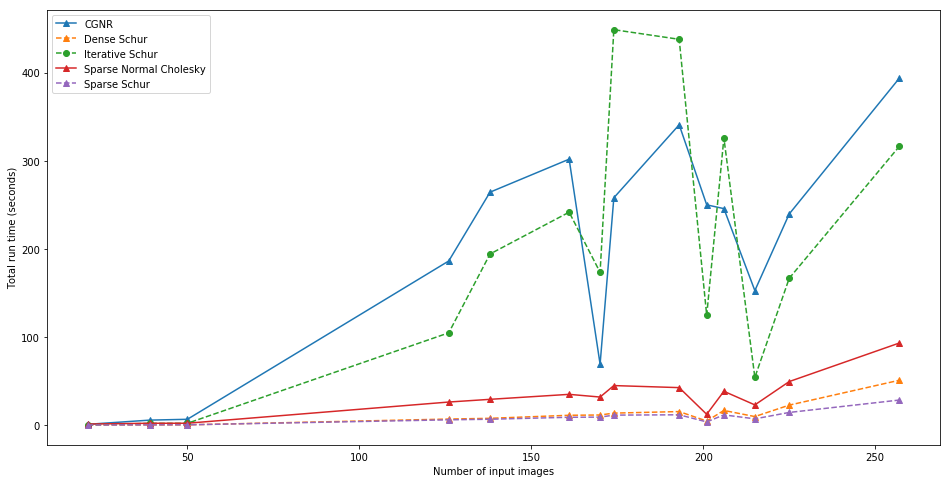

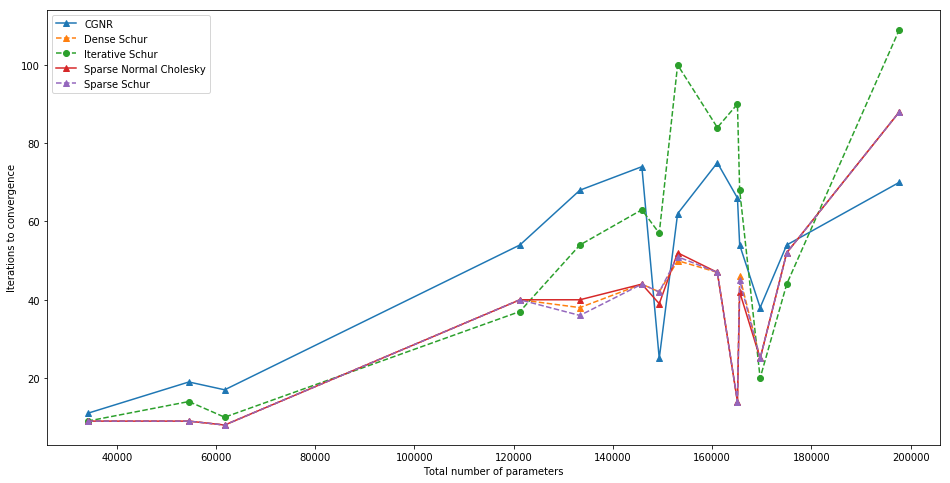

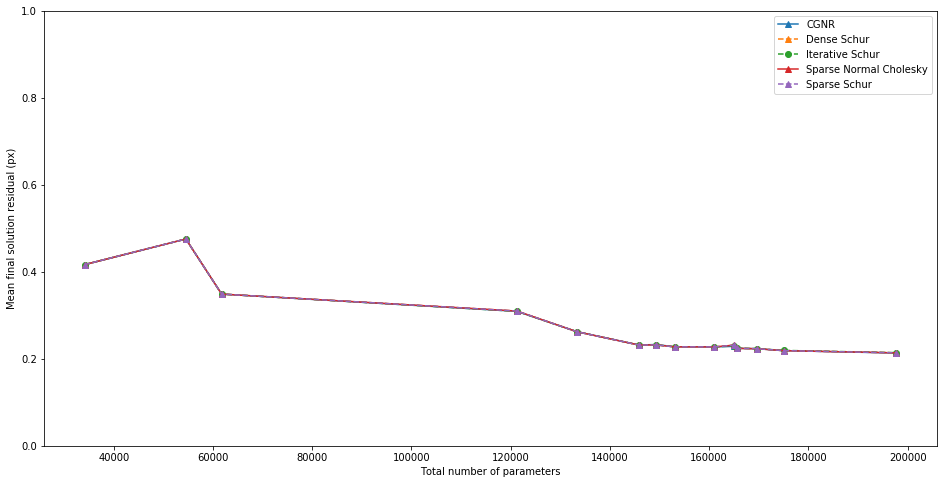

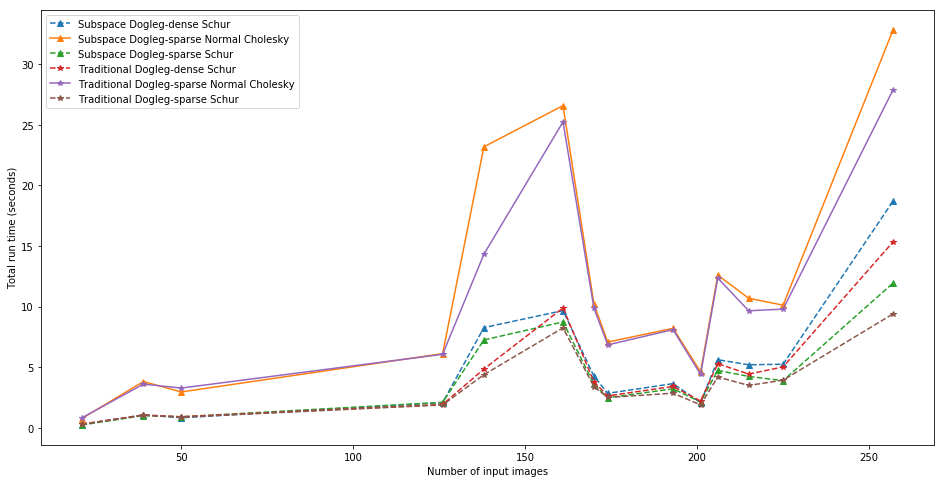

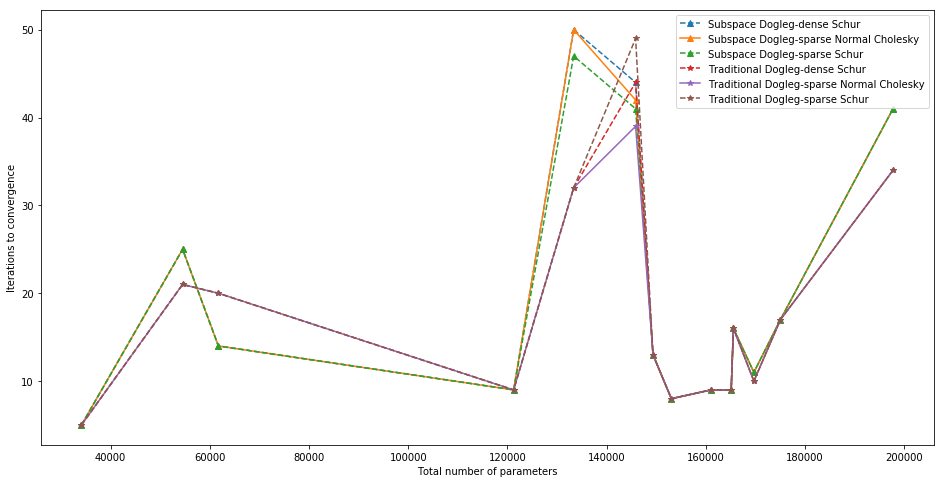

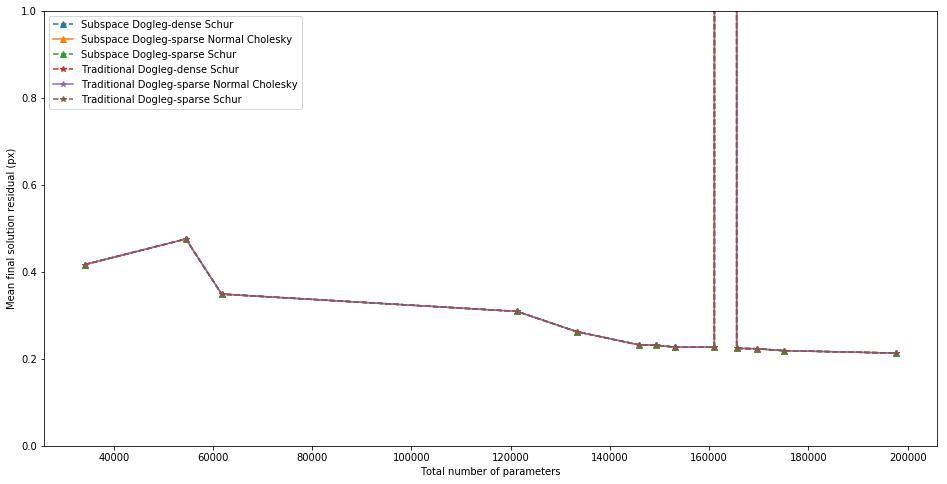

In [12]:
def plot_category(seq, category, x_axis='n_images', y_axis='time_seconds', **kw):
    frame = data[seq][category]
    methods = sorted(frame['method'].unique())

    plt.figure(figsize=(16,8))
    ax = plt.gca()
    for m in methods:
        # Set up this method's plot markers
        if 'dense' in m.lower() or 'cgnr' in m.lower():
            marker = '*'
        if 'iterative' in m.lower():
            marker = 'o'
        else:
            marker = '^'
            
        # Set up this method's line style
        if 'schur' in m.lower():
            style = '--'
        else:
            style = '-'
        
        # Make the experiment label human-readable
        label = m[m.find('-') + 1:]
        if label != "CGNR":
            label = screaming_snake_to_human(label)
            
        if category == 'dogleg':
            if 'traditional' in m.lower():
                marker = '*'
            elif 'subspace' in m.lower():
                marker = '^'
            else:
                raise ValueError("Unknown dogleg method category [{}]!".format(category))
            
        # Plot the experiment's line
        frame[frame['method'] == m].sort_values(by='n_images').plot(x_axis, y_axis, linestyle=style,
                                                                    marker=marker,
                                                                    ax=ax, label=label)
    ax.set_xlabel(x_pretty[x_axis])
    ax.set_ylabel(y_pretty[y_axis])
    
    top_hline = kw.get('top')
    if top_hline is not None:
        ax.axhline([top_hline], linestyle='--')
    
    if 'normalized' in y_axis:
        ax.set_ylim([0.0, 1.0])

    # Calling this in the end ensures proper positioning.
    ax.legend()
    
# TODO(andreib): Little skull icons for any marker over 'top'.
top_seconds = None
plot_category('trafalgar', 'lm', 'n_images', 'time_seconds', top=top_seconds)
print("Important note: the iteration count for iterative Shur is capped at 500, which is very high.")
# plot_category('trafalgar', 'lm', 'n_points', 'time_seconds', top=top_seconds)
plot_category('trafalgar', 'lm', 'n_params', 'iterations', top=top_seconds)
# plot_category('trafalgar', 'lm', 'n_points', 'final_cost', top=None)
# plot_category('trafalgar', 'lm', 'n_params', 'final_cost', top=None)
plot_category('trafalgar', 'lm', 'n_params', 'normalized_final_cost', top=None)

plot_category('trafalgar', 'dogleg', 'n_images', 'time_seconds', top=top_seconds)
plot_category('trafalgar', 'dogleg', 'n_params', 'iterations', top=top_seconds)
plot_category('trafalgar', 'dogleg', 'n_params', 'normalized_final_cost', top=None)


# Venice Experiments (Dogleg)

These sequences are typically much larger than the Trafalgar ones, meaning that LM approaches can take ~1h to solve some of them, which is a bit too long for practical purposes. The dogleg methods, on the other hand, seem to be much faster!

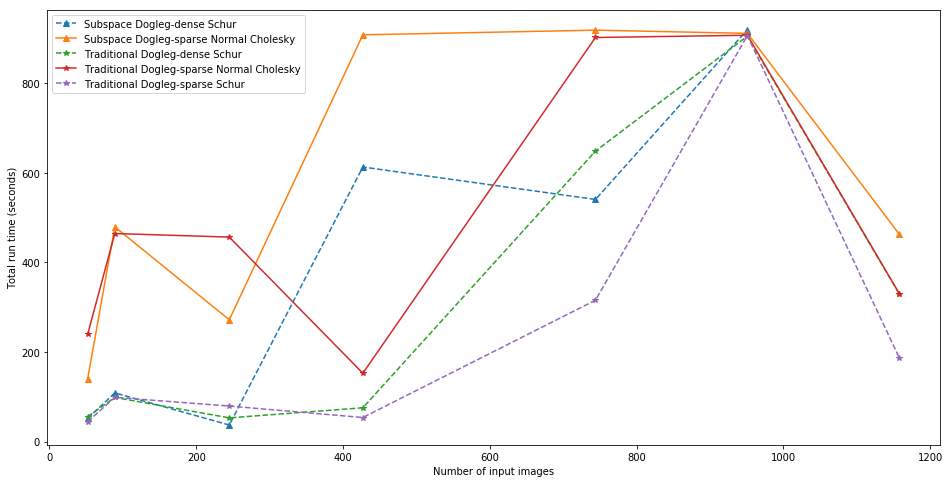

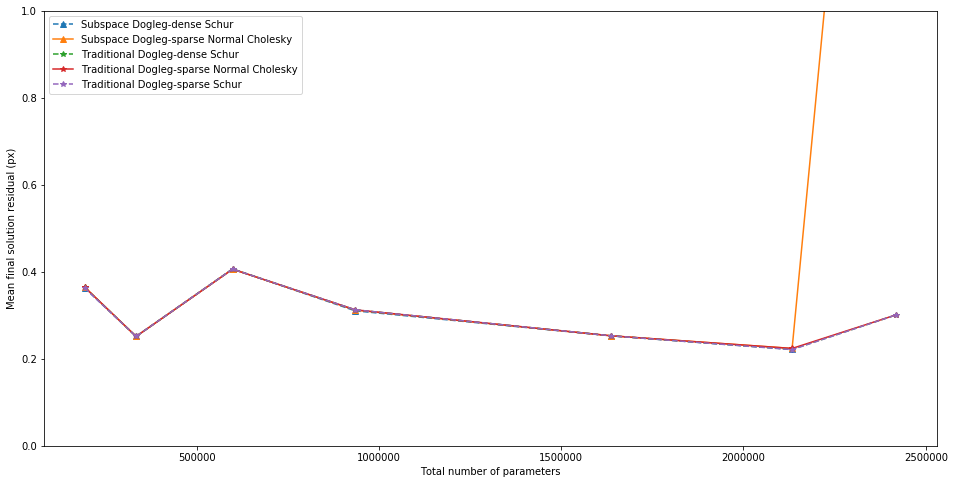

In [11]:
plot_category('venice', 'dogleg', 'n_images', 'time_seconds', top=top_seconds)
plot_category('venice', 'dogleg', 'n_params', 'normalized_final_cost', top=None)